In [65]:
import numpy as np
import tensorflow as tf
import wget
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io

### News Headlines Dataset for Sarcasm Detection

- https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
- This contains news headlines which are labeled as sarcastic or not

## 1. Load dataset

In [58]:
# Download the dataset
#wget.download('https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json')

In [59]:
# Load the JSON file
with open("Datasets/sarcasm.json", 'r') as f:
    news_datastore = json.load(f)

print(news_datastore[0])

urls = []
sentences = []
labels = []

for item in news_datastore:
    urls.append(item['article_link'])
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

print(len(sentences))

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}
26709


In [60]:
x_train, x_test, y_train, y_test = train_test_split(sentences,labels,test_size=0.251)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print("Train => ",x_train.shape,y_train.shape)
print("Test => ",x_test.shape,y_test.shape)

Train =>  (20005,) (20005,)
Test =>  (6704,) (6704,)


## 2. Text preprocessing

In [61]:
vec_layer_sentence = tf.keras.layers.TextVectorization(max_tokens = 10000,
                                                       output_mode='int',
                                                       output_sequence_length=32)
vec_layer_sentence.adapt(x_train)
vectorized_x_train = vec_layer_sentence(x_train)
vectorized_x_test = vec_layer_sentence(x_test)
print("Vocab size = ",vec_layer_sentence.vocabulary_size())
print(vectorized_x_train[0])
print(vectorized_x_test[1])

Vocab size =  10000
tf.Tensor(
[ 160   92  536 3355    1  152    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int64)
tf.Tensor(
[   1 2232   20   12    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(32,), dtype=int64)


## 3. Model (Deep Neural Network) : Build, compile and train

In [62]:
sarcasm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000,output_dim=16,input_length=32),

    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=24,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

sarcasm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

sarcasm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [63]:
sarcasm_model_hist = sarcasm_model.fit(x=vectorized_x_train, y=y_train,
               epochs=30,
               validation_data=(vectorized_x_test,y_test))

Epoch 1/30
626/626 [==============================] - 3s 4ms/step - loss: 0.5676 - accuracy: 0.6953 - val_loss: 0.4170 - val_accuracy: 0.8041
Epoch 2/30
626/626 [==============================] - 2s 3ms/step - loss: 0.3155 - accuracy: 0.8732 - val_loss: 0.3450 - val_accuracy: 0.8495
Epoch 3/30
626/626 [==============================] - 2s 3ms/step - loss: 0.2404 - accuracy: 0.9066 - val_loss: 0.3429 - val_accuracy: 0.8534
Epoch 4/30
626/626 [==============================] - 2s 3ms/step - loss: 0.1957 - accuracy: 0.9256 - val_loss: 0.3604 - val_accuracy: 0.8496
Epoch 5/30
626/626 [==============================] - 2s 3ms/step - loss: 0.1643 - accuracy: 0.9403 - val_loss: 0.4047 - val_accuracy: 0.8435
Epoch 6/30
626/626 [==============================] - 2s 3ms/step - loss: 0.1403 - accuracy: 0.9494 - val_loss: 0.4093 - val_accuracy: 0.8449
Epoch 7/30
626/626 [==============================] - 2s 3ms/step - loss: 0.1204 - accuracy: 0.9576 - val_loss: 0.4540 - val_accuracy: 0.8389
Epoch 

## 4. Visualize Results, Word Embeddings

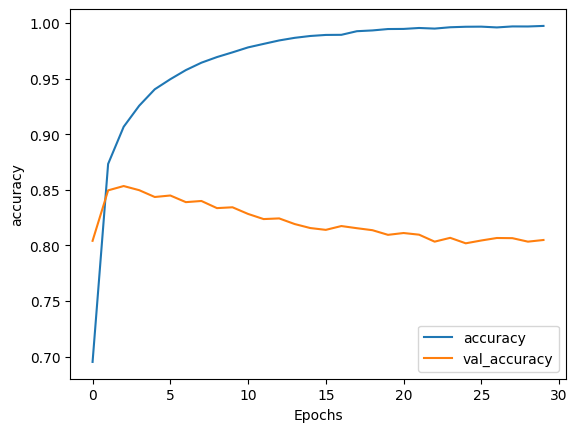

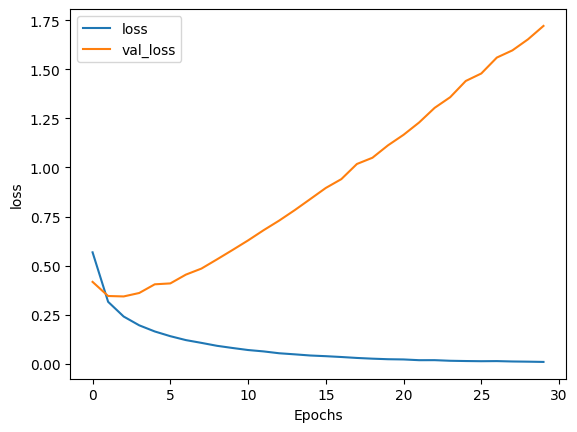

In [64]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(sarcasm_model_hist, "accuracy")
plot_graphs(sarcasm_model_hist, "loss")

In [66]:
embedding_layer = sarcasm_model.layers[0]
embeddings = embedding_layer.get_weights()[0] #Weights as single list of NumPy arrays of (input_dim rows,output_dim cols)
vocabulary = vec_layer_sentence.get_vocabulary()

In [67]:
out_v = io.open('Models/C3W2_Sarcasm/sarcasm_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('Models/C3W2_Sarcasm/sarcasm_metadata.tsv', 'w', encoding='utf-8')

for i in range(2,len(vocabulary)):
  if i <= 1 :
    continue  # skip 0, it's padding. skip 1, its OOV
  vec = embeddings[i]
  word = vocabulary[i]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")

out_v.close()
out_m.close()